# Deep Learning  


## TP3 : Méthodologie, Expérimentations et Régularisation 

Sylvain Lamprier (sylvain.lamprier@univ-angers.fr)

Supports adaptés de Nicolas Baskiotis (nicolas.baskiotis@sorbonne-univeriste.fr) et Benjamin Piwowarski (benjamin.piwowarski@sorbonne-universite.fr) -- MLIA/ISIR, Sorbonne Université

In [1]:
import torch
print("La version de torch est : ",torch.__version__)
print("Le calcul GPU est disponible ? ", torch.cuda.is_available())

import numpy as np
import sklearn
from sklearn.datasets import fetch_california_housing



## Chargement des données Boston et transformation en tensor.
boston = fetch_california_housing()
boston_x = torch.tensor(boston['data'],dtype=torch.float)
boston_y = torch.tensor(boston['target'],dtype=torch.float)
Xdim = boston_x.size(1)


La version de torch est :  2.1.1+cu121
Le calcul GPU est disponible ?  False


# Méthodologie expérimentale et boîte à outils
Pytorch dispose d'un ensemble d'outils qui permettent de simplifier les démarches expérimentales. Nous allons voir en particulier : 
* le DataLoader qui permet de gérer le chargement de données, le partitionement et la constitution d'ensembles de test et d'apprentissage; 
* le checkpointing qui permet de sauvegarder/charger les modèles en cours d'entraînement.
* le TensorBoard (qui vient de tensorflow) qui permet de suivre l'évolution en apprentissage de vos modèles.



## DataLoader
Le <a href=https://pytorch.org/docs/stable/data.html>**DataLoader**</a> et la classe associée <a href=https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset> **Dataset**</a>  permettent en particulier de :
* charger des données
* pré-processer les données
* de gérer les mini-batchs (sous-ensembles sur lequel on effectue une descente de gradient).

La classe **Dataset** est une classe abstraite qui nécessite l'implémentation que d'une seule méthode, ```__getitem__(self,index)``` : elle renvoie le i-ème objet du jeu de données (généralement un couple *(exemple,label)*. 

La classe **TensorDataset** est l'instanciation la plus courante d'un **Dataset**, elle permet de créer un objet **Dataset** à partir d'une liste de tenseurs qui renvoie pour un index $i$ donné le tuple contenant les $i$-èmes ligne de chaque tenseur.

La classe **DataLoader** permet essentiellement de randomiser et de constituer des mini-batchs de façon simple à partir d'une instance de **Dataset**. Chaque mini-batch est constitué d'exemples tirés aléatoirement dans le **Dataset** passé en paramètre et mis bout à bout dans des tenseurs. La méthode ```collate_fn(*args)``` est utilisée pour cela (nous verrons une customization de cette fonction dans une séance ultérieure). C'est ce générateur qui est généralement parcouru lors de l'apprentissage à chaque itération d'optimisation.

Voici un exemple de code pour utiliser le DataLoader : 


In [2]:
from torch.utils.data import DataLoader,TensorDataset, Dataset

## Création d'un dataset à partir des deux tenseurs d'exemples et de labels
train_data = TensorDataset(boston_x,boston_y)
## On peut indexer et connaitre la longueur d'un dataset
print(len(train_data),train_data[5])

## Création d'un DataLoader
## tailles de mini-batch de 16, shuffle=True permet de mélanger les exemples
# loader est un itérateur sur les mini-batchs des données
loader = DataLoader(train_data, batch_size=16,shuffle=True ) 

#Premier batch (aléatoire) du dataloader :
print(len(iter(loader)),next(iter(loader)))
EPOCHS = 10
EPS=1e-7
netSeq = torch.nn.Sequential(torch.nn.Linear(Xdim,5),torch.nn.Tanh(),torch.nn.Linear(5,1))
optim = torch.optim.Adam(params=netSeq.parameters(),lr=EPS)
mseloss = torch.nn.MSELoss()
# La boucle d'apprentissage :
for i in range(EPOCHS):
    cumloss = 0
    # On parcourt tous les exemples par batch de 16 (paramètre batch_size de DataLoader)
    for bx,by in loader:
        loss = mseloss(netSeq(bx).view(-1),by)
        optim.zero_grad()
        loss.backward()
        optim.step()
        cumloss += loss.item()
    if i % 100==0: print(f"iteration : {i}, loss : {cumloss/len(loader)}")



## Exemple d'un Dataset (sans utilité dans le cas présent, TensorDataset permet de faire la même chose)
class MyDataSet(Dataset):
  def __init__(self, x,y):
    self.x = x
    self.y = y
  def __getitem__(self,i):
    return self.x[i],self.y[i]
  def __len__(self):
    return len(self.x)

20640 (tensor([   4.0368,   52.0000,    4.7617,    1.1036,  413.0000,    2.1399,
          37.8500, -122.2500]), tensor(2.6970))
1290 [tensor([[ 5.3785e+00,  1.2000e+01,  5.8436e+00,  1.0076e+00,  3.9280e+03,
          4.2649e+00,  3.8120e+01, -1.2232e+02],
        [ 2.5000e+00,  2.1000e+01,  3.8978e+00,  1.0328e+00,  1.1800e+03,
          4.3066e+00,  3.3790e+01, -1.1830e+02],
        [ 3.9464e+00,  2.0000e+01,  7.6443e+00,  1.2835e+00,  6.6000e+02,
          3.4021e+00,  3.4050e+01, -1.1749e+02],
        [ 3.6902e+00,  4.1000e+01,  5.2213e+00,  1.0410e+00,  1.2900e+03,
          2.6434e+00,  3.6990e+01, -1.2201e+02],
        [ 6.1509e+00,  2.0000e+01,  6.4923e+00,  1.0308e+00,  1.0080e+03,
          3.1015e+00,  3.3060e+01, -1.1729e+02],
        [ 3.2917e+00,  5.2000e+01,  5.5642e+00,  9.6369e-01,  9.4800e+02,
          2.6480e+00,  3.3960e+01, -1.1739e+02],
        [ 4.0388e+00,  1.7000e+01,  4.8776e+00,  1.1085e+00,  1.8930e+03,
          4.3718e+00,  3.3510e+01, -1.1767e+02],
    

## Checkpointing
Les modèles Deep sont généralement long à apprendre. Afin de ne pas perdre des résultats en cours de calcul, il est fortement recommander de faire du **checkpointing**, c'est-à-dire d'enregistrer des points d'étapes du modèle en cours d'apprentissage pour pouvoir reprendre à n'importe quel moment l'apprentissage du modèle en cas de problème.  Il s'agit en pratique de sauvegarder l'état du modèle et de l'optimisateur (et de tout autre objet qui peut servir lors de l'apprentissage) toutes les n itérations. Toutes les variables d'intérêt sont en général disponibles par la méthode **state_dict()** des modèles et de l'optimiseur. 

En pratique, vous pouvez utilisé un code dérivé de celui ci-dessous.




In [3]:
import os
def save_state(epoch,model,optim,fichier):
      """ sauvegarde du modèle et de l'état de l'optimiseur dans fichier """
      state = {'epoch' : epoch, 'model_state': model.state_dict(), 'optim_state': optim.state_dict()}
      torch.save(state,fichier)
 
def load_state(fichier,model,optim):
      """ Si le fichier existe, on charge le modèle et l'optimiseur """
      epoch = 0
      if os.path.isfile(fichier):
          state = torch.load(fichier)
          model.load_state_dict(state['model_state'])
          optim.load_state_dict(state['optim_state'])
          epoch = state['epoch']
      return epoch

fichier = "/tmp/netSeq.pth"
save_state(0,netSeq,optim,fichier)


#netSeq = torch.nn.Sequential(torch.nn.Linear(Xdim,5),torch.nn.Tanh(),torch.nn.Linear(5,1))
#optim = torch.optim.Adam(params=netSeq.parameters(),lr=EPS)

#save_state(0,netSeq,optim,fichier)
start_epoch = load_state(fichier,netSeq,optim)
for epoch in range(start_epoch,EPOCHS):
    
    cumloss = 0
    for bx,by in loader:
        
        loss = mseloss(netSeq(bx).view(-1),by)
        optim.zero_grad()
        loss.backward()
        optim.step()
        cumloss += loss.item()
    if epoch % 10 ==0: save_state(epoch,netSeq,optim,fichier)
    print(epoch," ",cumloss/len(loader))



0   10.60458252115767
1   10.600012665386348
2   10.595448106943175
3   10.590880076460136
4   10.58631193693294
5   10.581745725084645
6   10.577179131766622
7   10.572613649590071
8   10.568048622072205
9   10.56348633692246



## GPU 
Afin d'utiliser un GPU lors des calculs, il est nécessaire de transférer les données et le modèle sur le GPU par l'intermédiaire de la fonction **to(device)** des tenseurs et des modules.  Il est impossible de faire une opération lorsqu'une partie des tenseurs sont sur GPU et l'autre sur CPU. Il faut que tous les tenseurs et paramètres soient sur le même device ! On doit donc s'assurer que le modèle, les exemples et les labels sont sur GPU pour faire les opérations.

Par ailleurs, on peut connaître le device sur lequel est chargé un tenseur par l'intermédiaire de ```.device``` (mais pas pour un modèle, il faut aller voir les paramètres dans ce cas).

Une manière simple d'utiliser un GPU quand il existe et donc d'avoir un code agnostique est la suivante : 


In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

loader = DataLoader(TensorDataset(boston_x,boston_y), batch_size=16,shuffle=True ) 

## On charge le modèle sur GPU
## A faire avant la déclaration de l'optimiseur, sinon les paramètres optimisés ne seront pas les mêmes! 

netSeq = torch.nn.Sequential(torch.nn.Linear(Xdim,5),torch.nn.Tanh(),torch.nn.Linear(5,1))
netSeq = netSeq.to(device)
optim = torch.optim.Adam(params=netSeq.parameters(),lr=EPS)

for i,(bx,by) in enumerate(loader):
    ## On charge le batch sur GPU
    bx, by = bx.to(device), by.to(device)
    loss = mseloss(netSeq(bx).view(-1),by)
    optim.zero_grad()
    loss.backward()
    optim.step()


print("Device du mini-batch : ", bx.device)


Device du mini-batch :  cpu



## TensorBoard

Durant l'apprentissage de vos modèles, il est agréable de visualiser de quelle manière évolue le coût, la précision sur l'ensemble de validation ainsi que d'autres éléments. TensorFlow dispose d'un outil très apprécié, le TensorBoard, qui permet de gérer très facilement de tels affichages. On retrouve tensorboard dans **Pytorch** dans ```torch.utils.tensorboard``` qui permet de faire le pont de pytorch vers cet outil. 

Le principe est le suivant :
* tensorboard fait tourner en fait un serveur web local qui va lire les fichiers de log dans un répertoire local. L'affichage se fait dans votre navigateur à partir d'un lien fourni lors du lancement de tensorboard.
* Les éléments que vous souhaitez visualiser (scalaire, graphes, distributions, histogrammes) sont écrits dans le fichier de log à partir d'un objet **SummaryWriter** .
* la méthode ```add_scalar(tag, valeur, global_step)``` permet de logger une valeur à un step donné, ```add_scalar(tag, tag_scalar_dic, global_step)``` un ensemble de valeurs par l'intermédiaire du dictionnaire ```tag_scalar_dic``` (un regroupement des scalaires est fait en fonction du tag passé, chaque sous-tag séparé par un **/**).

Il existe d'autres méthodes ```add_XXX``` pour visualiser par exemple des images, des histogrammes (cf <a href=https://pytorch.org/docs/stable/tensorboard.html>la doc </a>).

Le code suivant illustre une manière de l'utiliser. 

In [7]:
# Pour observer les courbes produites, il faut lancer tensorboard 
# à la main à partir du shell :  tensorboard --logdir logs
TB_PATH = "/tmp/logs/deep"
from torch.utils.tensorboard import SummaryWriter

class DeuxCouches(torch.nn.Module):
  def __init__(self):
    super(DeuxCouches,self).__init__()
    self.un = torch.nn.Linear(Xdim,5)
    self.act = torch.nn.Tanh()
    self.deux = torch.nn.Linear(5,1)
  def forward(self,x):
    return self.deux(self.act(self.un(x)))

EPS = 1e-7
EPOCHS=10
netSeq = torch.nn.Sequential(torch.nn.Linear(Xdim,5),torch.nn.Tanh(),torch.nn.Linear(5,1))
netDeuxCouches = DeuxCouches()
netSeq.name = "Sequentiel"
netDeuxCouches.name = "DeuxCouches"
## Obtention d'un SummaryWriter 
summary = SummaryWriter(f"{TB_PATH}/test")

mseloss = torch.nn.MSELoss()
for model in [netSeq, netDeuxCouches]:
    optim = torch.optim.Adam(params=model.parameters(),lr=EPS) 
    for i in range(EPOCHS):
        cumloss = 0
        for bx, by in loader:
            loss = mseloss(model(boston_x),boston_y.view(-1,1))
            optim.zero_grad()
            loss.backward()
            optim.step()  
            cumloss+= loss.item()
        summary.add_scalar(f"loss/{model.name}",cumloss,i)


## Dernières remarques et exemple typique de code
* Le graphe de calcul est instancié de manière dynamique sous pytorch, et cela consomme des ressources. Lorsqu'il n'y a pas de rétropropagation qui intervient - lors de l'évaluation d'un modèle par exemple -, il faut à tout prix éviter de le calculer. L'environnement **torch.no_grad()** permet de désactiver temporairement l'instanciation du graphe. **Toutes les procédures d'évaluation doivent se faire dans cet environnement afin d'économiser du temps !**
* Pour certains modules, le comportement est différent entre l'évaluation et l'apprentissage (pour le dropout ou la batchnormalisation par exemple, ou pour les RNNs). Afin d'indiquer à pytorch dans quelle phase on se situe, deux méthodes sont disponibles dans la classe module,  **.train()** et **.eval()** qui permettent de basculer entre les deux environnements.

Les deux fonctionalités sont très différentes : **no_grad** agit au niveau du graphe de calcul et désactive sa construction (comme si les variables avaient leur propriété **requires_grad** à False), alors que **eval/train** agissent au niveau du module et influence le comportement du module.

Vous trouverez ci-dessous un exemple typique de code pytorch qui reprend l'ensemble des éléments de ce tutoriel. Vous êtes prêt maintenant à expérimenter la puissance de ce framework.

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import time
import os
TB_PATH = "/tmp/logs/module1"
MODEL_PATH = "/tmp/models"
os.makedirs(MODEL_PATH,exist_ok=True)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


In [9]:
def save_state(fichier,epoch,model,optim):
    state = {'epoch' : epoch, 'model_state': model.state_dict(), 'optim_state': optim.state_dict()}
    torch.save(state,fichier)

def load_state(fichier,model,optim):
    epoch = 0
    if os.path.isfile(fichier):
        state = torch.load(fichier)
        model.load_state_dict(state['model_state'])
        optim.load_state_dict(state['optim_state'])
        epoch = state['epoch']
    return epoch


def train(model, loss, epochs, train_loader, test_loader,lr=1e-3):
    # On créé un writer avec la date du modèle pour s'y retrouver
    check_file = f"{MODEL_PATH}/{model.name}.pth"
    summary = SummaryWriter(f"{TB_PATH}/{model.name}")
    optim = torch.optim.Adam(params=model.parameters(),lr=lr)
    start_epoch = load_state(check_file,model,optim)
    for epoch in range(start_epoch,epochs):
        # Apprentissage
        # .train() inutile tant qu'on utilise pas de normalisation ou de récurrent
        model.train()
        cumloss = 0
        for xbatch, ybatch in train_loader:
            xbatch, ybatch = xbatch.to(device), ybatch.to(device)
            outputs = model(xbatch)
            l = loss(outputs.view(-1),ybatch)
            optim.zero_grad()
            l.backward()
            optim.step()
            cumloss += l.item()
        summary.add_scalar("loss/train",  cumloss/len(train_loader),epoch)
     
        if epoch % 10 == 0: 
            save_state(check_file,epoch,model,optim)
            # Validation
            # .eval() inutile tant qu'on utilise pas de normalisation ou de récurrent
            model.eval()
            with torch.no_grad():
                cumloss = 0
                for xbatch, ybatch in test_loader:
                    xbatch, ybatch = xbatch.to(device), ybatch.to(device)
                    outputs = model(xbatch)
                    cumloss += loss(outputs.view(-1),ybatch).item()
            summary.add_scalar("loss/validation", cumloss/len(test_loader) ,epoch)

In [10]:

# Datasets
from sklearn.datasets import fetch_california_housing
boston = fetch_california_housing() ## chargement des données
all_data = torch.tensor(boston['data'],dtype=torch.float)
all_labels = torch.tensor(boston['target'],dtype=torch.float)

# Il est toujours bon de normaliser
all_data = (all_data-all_data.mean(0))/all_data.std(0)
all_labels = (all_labels-all_labels.mean())/all_labels.std()

train_tensor_data = TensorDataset(all_data, all_labels)

# Split en 80% apprentissage et 20% test
train_size = int(0.8 * len(train_tensor_data))
validate_size = len(train_tensor_data) - train_size
train_data, valid_data = torch.utils.data.random_split(train_tensor_data, [train_size, validate_size])


EPOCHS = 10
BATCH_SIZE = 16

train_loader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)

net = torch.nn.Sequential(torch.nn.Linear(all_data.size(1),5),torch.nn.Tanh(),torch.nn.Linear(5,1))
net.name = "mon_premier_reseau"+time.asctime()

net = net.to(device)
train(net,torch.nn.MSELoss(),EPOCHS,train_loader,valid_loader,lr=1e-5)


# Expérimentations
## Jeu de données MNIST
Ce jeu de données est l'équivalent du *Hello world* en programmation. Chaque donnée est un chiffre manuscrit (de 0 à 9). Les lignes suivantes vous permettent de charger le jeu de données.


In [144]:
import numpy as np

# Modules (torch, nn, F et optim)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
from torch.nn.functional import one_hot
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Progrès
from tqdm import tqdm
from tqdm.autonotebook import tqdm
#from tqdm import tqdm_notebook as tqdm

#matpotlib 
import matplotlib
import matplotlib.pyplot as plt


import time
import os
from tensorboard import notebook


TB_PATH = "/tmp/logs/deep_tp3"
from torch.utils.tensorboard import SummaryWriter

MODEL_PATH = "/tmp/models"
os.makedirs(MODEL_PATH,exist_ok=True)


mean=[0.5]
std=[0.5]
batchsize=128

#Transformations à appliquer sur le dataset (transformation des images en tenseurs et normalization pour obtenir des valeurs entre -1 et 1)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std)])

# Téléchargement des données (via le dataset specifique MNIST de pytorch)
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
print(len(trainset))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, pin_memory=True, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, pin_memory=True, shuffle=False)




60000


## Visualisation d'une image


torch.Size([128, 1, 28, 28])


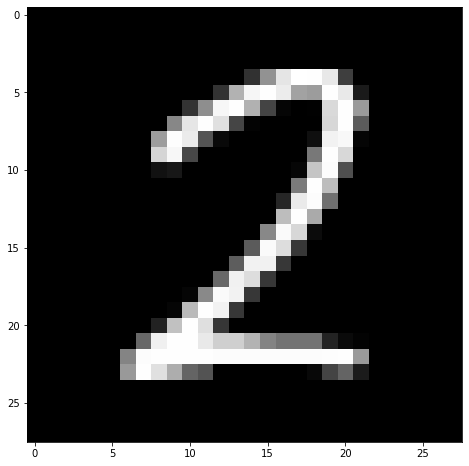

In [145]:
def unnormalize(img):
  if img.dim()==2 or ((img.dim()==3) and (img.size()[0]==1)):
      return img*std[0]+mean[0]
  return img * img.new(std).view(3, 1, 1) + img.new(mean).view(3, 1, 1)

# Recuperation du premier batch
imgs,labs=next(iter(trainloader))
# dimension of images (flattened)
HEIGHT,WIDTH = imgs.shape[2],imgs.shape[3] # taille de l'image

INPUT_DIM = HEIGHT * WIDTH

#Visualisation de la première image
print(imgs.size())
img = unnormalize(imgs[0]) # pour retrouver l'image d'origine (avant normalisation)
fig=plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(),cmap='Greys_r')

In [192]:

from torch.utils.data import DataLoader,TensorDataset, Dataset

## On utilise qu'une partie du training test pour mettre en évidence le sur-apprentissage
TRAIN_RATIO = 0.01
train_length = int(len(trainset)*TRAIN_RATIO)

ds_train, ds_test =  torch.utils.data.random_split(trainset, (train_length, len(trainset)- train_length))

#On utilise un DataLoader pour faciliter les manipulations, on fixe  la taille du mini batch à 300
train_loader = DataLoader(ds_train,batch_size=300,shuffle=True)
test_loader = DataLoader(ds_test,batch_size=300,shuffle=False)

print(next(iter(train_loader)))
def accuracy(yhat,y):
    # y encode les indexes, s'assurer de la bonne taille de tenseur
    assert len(y.shape)==1 or y.size(1)==1
    return (torch.argmax(yhat,1).view(y.size(0),-1)== y.view(-1,1)).double().mean()

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1.,

##  <span class="alert-success"> Exercice : Classification multi-labels, nombre de couches, fonction de coût </span>

L'objectif est de classer chaque image parmi les 10 chiffres qu'ils représentent. Le réseau aura donc 10 sorties, une par classe, chacune représentant la probabilité d'appartenance à chaque classe. Pour garantir une distribution de probabilité en sortie, il faut utiliser le module <a href=https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html> **Softmax** </a> : $$\texttt{Softmax}(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^d x_j}$$ qui permet de normaliser le vecteur de sortie.

* Faites quelques exemples de réseau à 1, 2, 3 couches et en faisant varier les nombre de neurones par couche. Utilisez un coût moindre carré dans un premier temps. Pour superviser ce coût, on doit construire le vecteur one-hot correspondant à la classe : un vecteur qui ne contient que des 0 sauf à l'index de la classe qui contient un 1 (utilisez ```torch.nn.functional.one_hot```).  Comparez les courbes de coût et d'erreurs en apprentissage et en test selon l'architecture.
* Le coût privilégié en multi-classe est la *cross-entropy**. Ce coût représente la négative log-vraisemblance : $$NNL(y,\mathbf{x}) = -x_{y} $$ en notant $y$ l'indice de la classe et $\mathbf{x}$ le vecteur de log-probabilité inféré. On peut utiliser soit son implémentation par le module <a href=https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss>**NLLLoss**</a>, soit - plus pratique - le module <a href=https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html>**CrossEntropyLoss** <a>  qui combine un *logSoftmax* et la cross entropie, ce qui évite d'avoir à ajouter un module de *Softmax* en sortie du réseau. Utilisez ce dernier coût et observez les changements.
* Changez la fonction d'activation en une ReLU et observez l'effet.

In [147]:
# Construire un réseau générique NN qui étend nn.Module, dont on la construction se fait par:
# LinearMultiClass(inSize, outSize, layers=[], finalActivation=None, activation=nn.Tanh), où:
# inSize est la dimension des entrées, outSize la dimension des sorties
# liste des tailles des éventuelles couches cachées
# finalActivation est la fonction d'activation a appliquer sur la sortie (si pas None)
# et activation la fonction d'activation à appliquer après chaque couche cachée

class LinearMultiClass(nn.Module):
    def __init__(self, inSize, outSize, layers=[], finalActivation=None, activation=nn.Tanh):
        super(LinearMultiClass, self).__init__()
        
        # Liste des couches linéaires
        self.neuralNetwork = nn.ModuleList()
        
        # Couche d'entrée
        self.neuralNetwork.append(nn.Linear(inSize, layers[0]) if layers else nn.Linear(inSize, layers[0]))
        
        # Couches cachées
        for i in range(len(layers)-1):
            self.neuralNetwork.append(nn.Linear(layers[i], layers[i+1]))
        
        # Couche de sortie
        self.neuralNetwork.append(nn.Linear(layers[-1] if layers else inSize, outSize))
        
        # Fonction d'activation après chaque couche cachée
        self.activation = activation()
        
        # Fonction d'activation pour la sortie (si présente)
        self.finalActivation = finalActivation() if finalActivation else None

    def forward(self, x):
        for layer in self.neuralNetwork[:-1]:
            x = self.activation(layer(x))
        
        # Couche de sortie avec fonction d'activation
        x = self.neuralNetwork[-1](x)
        if self.finalActivation:
            x = self.finalActivation(x)
        return x

In [ ]:
      


# Comparer les deux types de coûts décrits si dessus (MSE avec un vecteur one hot cible et CrossEntropie qui paraît plus adapté pour ce cas) 
# Pour la cross entropie, on utilise nn.CrossEntropyLoss, qui n'a pas besoin que l'on ne rescale les sorties (la cross entropy combine un softmax + NLLloss)
# Si on utilisait une BCE loss (qui n'est pas approprié ici, vu que les classes sont dépendantes : une seule classe est visée par exemple),
# dans ce cas il faudrait ajouter une sigmoide en derniere couche.


In [203]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import os

# Fonction pour sauvegarder l'état du modèle
def save_state(fichier, epoch, model, optim):
    state = {'epoch': epoch, 'model_state': model.state_dict(), 'optim_state': optim.state_dict()}
    torch.save(state, fichier)

# Fonction pour charger l'état du modèle
def load_state(fichier, model, optim):
    epoch = 0
    if os.path.isfile(fichier):
        state = torch.load(fichier)
        model.load_state_dict(state['model_state'])
        optim.load_state_dict(state['optim_state'])
        epoch = state['epoch']
    return epoch

def train(model, loss, epochs, train_loader, test_loader,lr=1e-3):
    check_file = f"{MODEL_PATH}/{model.name}.pth"
    summary = SummaryWriter(f"{TB_PATH}/{model.name}")
    optim = torch.optim.Adam(params=model.parameters(),lr=lr)
    #start_epoch = load_state(check_file,model,optim)
    
    for epoch in range(0, epochs):
        ###############    TRAIN    ########################
        model.train()
        cumloss = 0
        acc_train = 0
        
        for inputs, labels in train_loader:
            optim.zero_grad()
            outputs = model(inputs.view(-1, 28 * 28))            
            l=None
            if isinstance(loss, torch.nn.MSELoss):
                one_hot_labels = F.one_hot(labels, num_classes=10).float()
                l = loss(outputs, one_hot_labels)
            else:
                l = loss(outputs, labels)
            l.backward()
            optim.step()
            cumloss += l.item()
            acc_train += accuracy(outputs, labels)

        acc_train /= len(train_loader) 
        avg_train_loss = cumloss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, ",f"Train accuracy: {acc_train:.4f}")
        summary.add_scalar(f'{model.name}/Training Loss', avg_train_loss, epoch)
        summary.add_scalar(f'{model.name}/Training Accuracy', acc_train, epoch)
        save_state(check_file, epoch, model, optim)

        ###############    TEST    ########################
        
        model.eval()
        cumloss = 0
        acc_test = 0
        model.eval() 
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs.view(-1, 28 * 28))
                l=None
                if isinstance(loss, torch.nn.MSELoss):
                    one_hot_labels = F.one_hot(labels, num_classes=10).float()
                    l = loss(outputs, one_hot_labels)
                else:
                    l = loss(outputs, labels)
                cumloss += l.item()
                acc_test += accuracy(outputs, labels)

        acc_test /= len(test_loader) 
        avg_test_loss = cumloss / len(test_loader)
        summary.add_scalar(f'{model.name}/Test Loss', avg_test_loss, epoch)
        summary.add_scalar(f'{model.name}/Test Accuracy', acc_test, epoch)
        print(f"Epoch {epoch + 1}/{epochs}, ",f"Test accuracy: {acc_test:.4f}")
                
    

architectures = [
    {"name": "model1", "layers": [128], "loss": nn.CrossEntropyLoss(),"finalActivation": None, "activation": nn.ReLU},
    {"name": "model2", "layers": [128], "loss": nn.CrossEntropyLoss(), "finalActivation": None, "activation": nn.Tanh},
    {"name": "model3", "layers": [128], "loss": nn.MSELoss(), "finalActivation": nn.Softmax, "activation": nn.ReLU},
    {"name": "model4", "layers": [128], "loss": nn.MSELoss(), "finalActivation": nn.Softmax, "activation": nn.Tanh},
    {"name": "model5", "layers": [64, 32], "loss": nn.MSELoss(),"finalActivation": nn.Softmax, "activation": nn.ReLU},
    {"name": "model6", "layers": [64, 32], "loss": nn.CrossEntropyLoss(),"finalActivation": None, "activation": nn.ReLU},
    {"name": "model7", "layers": [128, 64, 32], "loss": nn.CrossEntropyLoss(),"finalActivation": None, "activation": nn.ReLU},
]

in_size=INPUT_DIM
out_size = 10
EPOCHS = 10
TRAIN_RATIO = 0.8
train_length = int(len(trainset)*TRAIN_RATIO)
ds_train, ds_test =  torch.utils.data.random_split(trainset, (train_length, len(trainset)- train_length))
train_loader = DataLoader(ds_train,batch_size=300,shuffle=True)
test_loader = DataLoader(ds_test,batch_size=300,shuffle=False)

for arch in architectures:
    print(f"\nTraining model {arch['name']}")
    model = LinearMultiClass(in_size, out_size, layers=arch.get("layers"), finalActivation=arch.get("finalActivation"), activation=arch.get("activation"))
    model.name = arch.get("name")
    model.to(device)
    print(model)
    loss = arch.get("loss")
    train(model,loss, EPOCHS,train_loader, test_loader)



Training model model1
LinearMultiClass(
  (neuralNetwork): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
  (activation): ReLU()
)
Epoch 1/10,  Train accuracy: 0.8367
Epoch 1/10,  Test accuracy: 0.8991
Epoch 2/10,  Train accuracy: 0.9114
Epoch 2/10,  Test accuracy: 0.9180
Epoch 3/10,  Train accuracy: 0.9269
Epoch 3/10,  Test accuracy: 0.9291
Epoch 4/10,  Train accuracy: 0.9401
Epoch 4/10,  Test accuracy: 0.9398
Epoch 5/10,  Train accuracy: 0.9501
Epoch 5/10,  Test accuracy: 0.9500
Epoch 6/10,  Train accuracy: 0.9575
Epoch 6/10,  Test accuracy: 0.9560
Epoch 7/10,  Train accuracy: 0.9628
Epoch 7/10,  Test accuracy: 0.9587
Epoch 8/10,  Train accuracy: 0.9677
Epoch 8/10,  Test accuracy: 0.9602
Epoch 9/10,  Train accuracy: 0.9699
Epoch 9/10,  Test accuracy: 0.9627
Epoch 10/10,  Train accuracy: 0.9731
Epoch 10/10,  Test accuracy: 0.9642

Training model model2
LinearMultiClass(
  (neuralNetwork): Modu

/home/etud/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/10,  Train accuracy: 0.8299
Epoch 1/10,  Test accuracy: 0.9048
Epoch 2/10,  Train accuracy: 0.9105
Epoch 2/10,  Test accuracy: 0.9224
Epoch 3/10,  Train accuracy: 0.9229
Epoch 3/10,  Test accuracy: 0.9302
Epoch 4/10,  Train accuracy: 0.9339
Epoch 4/10,  Test accuracy: 0.9348
Epoch 5/10,  Train accuracy: 0.9434
Epoch 5/10,  Test accuracy: 0.9456
Epoch 6/10,  Train accuracy: 0.9511
Epoch 6/10,  Test accuracy: 0.9482
Epoch 7/10,  Train accuracy: 0.9571
Epoch 7/10,  Test accuracy: 0.9502
Epoch 8/10,  Train accuracy: 0.9610
Epoch 8/10,  Test accuracy: 0.9556
Epoch 9/10,  Train accuracy: 0.9653
Epoch 9/10,  Test accuracy: 0.9581
Epoch 10/10,  Train accuracy: 0.9691
Epoch 10/10,  Test accuracy: 0.9614

Training model model4
LinearMultiClass(
  (neuralNetwork): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
  (activation): Tanh()
  (finalActivation): Softmax(dim=None)
)
Epoch 1/10,  Train accura

##  <span class="alert-success"> Exercice : Régularisation des réseaux </span>

### Pénalisation des couches
Une première technique pour éviter le sur-apprentissage est de régulariser chaque couche par une pénalisation sur les poids, i.e. de favoriser des poids faibles. On parle de pénalisation L1 lorsque la pénalité est de la forme $\|W\|_1$ et L2 lorsque la norme L2 est utilisée : $\|W\|_2^2$. En pratique, cela consiste à rajouter à la fonction de coût globale du réseau un terme en $\lambda Pen(W)$ pour les paramètres de chaque couche que l'on veut régulariser.

Expérimentez avec une norme L2 dans $\{0,10^{-5},10^{-4},10^{-3},10^{-2},\}$, l'évolution de la pénalisation et du coût en fonction du nombre d'époques. Vous pouvez aussi observer les histogrammes de la distribution des poids des différentes couches en utilisant la fonction addWeightsHisto ci dessous.  Utilisez pour ces experiences un réseau à 3 couches chacune de taille 100 et un coût de CrossEntropy.


In [206]:
# requiert que les modules soient enregistrés dans une liste model.layers
def addWeightsHisto(writer,model,epoch):                
    ix = 0
    for module in model.layers:
        if isinstance(module, nn.Linear):
           writer.add_histogram(f'linear/{ix}/weight',module.weight, epoch)
           ix += 1

class LinearMultiClass(nn.Module):
    def __init__(self, inSize, outSize, layers=[], finalActivation=None, activation=nn.Tanh):
        super(LinearMultiClass, self).__init__()
        
        # Liste des couches linéaires
        self.neuralNetwork = nn.ModuleList()
        self.layers = nn.ModuleList()
        
        # Couche d'entrée
        input_layer = nn.Linear(inSize, layers[0]) if layers else nn.Linear(inSize, layers[0])
        self.neuralNetwork.append(input_layer)
        self.layers.append(input_layer)

        # Couches cachées
        for i in range(len(layers)-1):
            hidden_layer = nn.Linear(layers[i], layers[i+1])
            self.neuralNetwork.append(hidden_layer)
            self.layers.append(hidden_layer)

        # Couche de sortie
        output_layer = nn.Linear(layers[-1] if layers else inSize, outSize)
        self.neuralNetwork.append(output_layer)
        self.layers.append(output_layer)

        # Fonction d'activation après chaque couche cachée
        self.activation = activation()
        
        # Fonction d'activation pour la sortie (si présente)
        self.finalActivation = finalActivation() if finalActivation else None

    def forward(self, x):
        for layer in self.neuralNetwork[:-1]:
            x = self.activation(layer(x))
        
        # Couche de sortie avec fonction d'activation
        x = self.neuralNetwork[-1](x)
        if self.finalActivation:
            x = self.finalActivation(x)
        return x

def train(model, loss, epochs, train_loader, test_loader,lr=1e-3,L2_norm=0):
    check_file = f"{MODEL_PATH}/{model.name}.pth"
    summary = SummaryWriter(f"{TB_PATH}/{model.name}")
    optim = torch.optim.Adam(params=model.parameters(),lr=lr,weight_decay=L2_norm)
    #start_epoch = load_state(check_file,model,optim)
    
    for epoch in range(0, epochs):
        ###############    TRAIN    ########################
        model.train()
        cumloss = 0
        acc_train = 0
        
        for inputs, labels in train_loader:
            optim.zero_grad()
            outputs = model(inputs.view(-1, 28 * 28))            
            l=None
            if isinstance(loss, torch.nn.MSELoss):
                one_hot_labels = F.one_hot(labels, num_classes=10).float()
                l = loss(outputs, one_hot_labels)
            else:
                l = loss(outputs, labels)
            l.backward()
            optim.step()
            cumloss += l.item()
            acc_train += accuracy(outputs, labels)

        acc_train /= len(train_loader) 
        avg_train_loss = cumloss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, ",f"Train accuracy: {acc_train:.4f}")
        summary.add_scalar(f'{model.name}/Training Loss', avg_train_loss, epoch)
        summary.add_scalar(f'{model.name}/Training Accuracy', acc_train, epoch)
        save_state(check_file, epoch, model, optim)
        addWeightsHisto(summary, model, epoch)
        ###############    TEST    ########################
        
        model.eval()
        cumloss = 0
        acc_test = 0
        model.eval() 
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs.view(-1, 28 * 28))
                l=None
                if isinstance(loss, torch.nn.MSELoss):
                    one_hot_labels = F.one_hot(labels, num_classes=10).float()
                    l = loss(outputs, one_hot_labels)
                else:
                    l = loss(outputs, labels)
                cumloss += l.item()
                acc_test += accuracy(outputs, labels)

        acc_test /= len(test_loader) 
        avg_test_loss = cumloss / len(test_loader)
        summary.add_scalar(f'{model.name}/Test Loss', avg_test_loss, epoch)
        summary.add_scalar(f'{model.name}/Test Accuracy', acc_test, epoch)
        print(f"Epoch {epoch + 1}/{epochs}, ",f"Test accuracy: {acc_test:.4f}")
                

in_size=INPUT_DIM
out_size = 10
EPOCHS = 10
TRAIN_RATIO = 0.8
train_length = int(len(trainset)*TRAIN_RATIO)
ds_train, ds_test =  torch.utils.data.random_split(trainset, (train_length, len(trainset)- train_length))
train_loader = DataLoader(ds_train,batch_size=300,shuffle=True)
test_loader = DataLoader(ds_test,batch_size=300,shuffle=False)

for L2_norm_value in [0, 1e-5, 1e-4, 1e-3, 1e-2]:    
    model = LinearMultiClass(in_size, out_size, layers=[100, 100, 100], finalActivation=None, activation=nn.Tanh)
    model.name = f"Model_L2_{L2_norm_value}"
    print(model)
    train(model, nn.CrossEntropyLoss(), EPOCHS, train_loader, test_loader, lr=1e-5, L2_norm=L2_norm_value)   


LinearMultiClass(
  (neuralNetwork): ModuleList(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1-2): 2 x Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1-2): 2 x Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
  (activation): Tanh()
)
Epoch 1/10,  Train accuracy: 0.2327
Epoch 1/10,  Test accuracy: 0.4098
Epoch 2/10,  Train accuracy: 0.5230
Epoch 2/10,  Test accuracy: 0.5987
Epoch 3/10,  Train accuracy: 0.6237
Epoch 3/10,  Test accuracy: 0.6416
Epoch 4/10,  Train accuracy: 0.6457
Epoch 4/10,  Test accuracy: 0.6571
Epoch 5/10,  Train accuracy: 0.6609
Epoch 5/10,  Test accuracy: 0.6666
Epoch 6/10,  Train accuracy: 0.6787
Epoch 6/10,  Test accuracy: 0.6907
Epoch 7/10,  Train accuracy: 0.7005
Epoch 7/10,  Test accuracy: 0.7192
Epoch 8/10,  Tr

### Dropout

Une autre technique très utilisée est le <a href=https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html> **Dropout** </a>. L’idée du Dropout est proche du moyennage de modèle : en entraînant k modèles de manière indépendante, on réduit la variance du modèle. Entraîner k modèles présente un surcoût non négligeable, et l’intérêt du Dropout est de réduire la complexité mémoire/temps de calcul. Le Dropout consiste à chaque itération à *geler* certains neurones aléatoirement dans le réseau en fixant leur sortie à zéro. Cela a pour conséquence de rendre plus robuste le réseau.

Le comportement du réseau est donc différent en apprentissage et en inférence. Il est obligatoire d'utiliser ```model.train()``` et ```model.eval()``` pour différencier les comportements.
Testez sur quelques réseaux pour voir l'effet du dropout.

In [207]:
import torch.nn.functional as F

class LinearMultiClass(nn.Module):
    def __init__(self, inSize, outSize, layers=[], finalActivation=None, activation=nn.Tanh, dropout_prob=0):
        super(LinearMultiClass, self).__init__()

        # Liste des couches linéaires
        self.neuralNetwork = nn.ModuleList()

        # Liste supplémentaire pour enregistrer les modules
        self.layers = nn.ModuleList()

        # Couche d'entrée
        input_layer = nn.Linear(inSize, layers[0]) if layers else nn.Linear(inSize, layers[0])
        self.neuralNetwork.append(input_layer)
        self.layers.append(input_layer)

        # Couches cachées avec Dropout
        for i in range(len(layers)-1):
            hidden_layer = nn.Linear(layers[i], layers[i+1])
            dropout = nn.Dropout(p=dropout_prob)
            self.neuralNetwork.extend([hidden_layer, dropout])
            self.layers.extend([hidden_layer, dropout])

        # Couche de sortie
        output_layer = nn.Linear(layers[-1] if layers else inSize, outSize)
        self.neuralNetwork.append(output_layer)
        self.layers.append(output_layer)

        # Fonction d'activation après chaque couche cachée
        self.activation = activation()

        # Fonction d'activation pour la sortie (si présente)
        self.finalActivation = finalActivation() if finalActivation else None

    def forward(self, x):
        for layer in self.neuralNetwork[:-1]:
            if isinstance(layer, nn.Dropout):
                x = F.dropout(x, training=self.training)
            else:
                x = self.activation(layer(x))

        # Couche de sortie avec fonction d'activation
        x = self.neuralNetwork[-1](x)
        if self.finalActivation:
            x = self.finalActivation(x)
        return x


architectures = [
    {"name": "model1", "layers": [128], "loss": nn.CrossEntropyLoss(),"finalActivation": None, "activation": nn.ReLU, "dropoutProb": 0.5},
    {"name": "model2", "layers": [128], "loss": nn.CrossEntropyLoss(),"finalActivation": None, "activation": nn.ReLU, "dropoutProb": 0.2},
    {"name": "model3", "layers": [128], "loss": nn.CrossEntropyLoss(),"finalActivation": None, "activation": nn.ReLU, "dropoutProb": 0.1}
]

in_size=INPUT_DIM
out_size = 10
EPOCHS = 10
TRAIN_RATIO = 0.8
train_length = int(len(trainset)*TRAIN_RATIO)
ds_train, ds_test =  torch.utils.data.random_split(trainset, (train_length, len(trainset)- train_length))
train_loader = DataLoader(ds_train,batch_size=300,shuffle=True)
test_loader = DataLoader(ds_test,batch_size=300,shuffle=False)

for arch in architectures:
    print(f"\nTraining model {arch['name']}")
    model = LinearMultiClass(in_size, out_size, layers=arch.get("layers"), finalActivation=arch.get("finalActivation"), activation=arch.get("activation"), dropout_prob=arch.get("dropoutProb"))
    model.name = arch.get("name")
    model.to(device)
    print(model)
    loss = arch.get("loss")
    train(model,loss, EPOCHS,train_loader, test_loader)



Training model model1
LinearMultiClass(
  (neuralNetwork): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
  (activation): ReLU()
)
Epoch 1/10,  Train accuracy: 0.8353
Epoch 1/10,  Test accuracy: 0.8978
Epoch 2/10,  Train accuracy: 0.9077
Epoch 2/10,  Test accuracy: 0.9202
Epoch 3/10,  Train accuracy: 0.9226
Epoch 3/10,  Test accuracy: 0.9247
Epoch 4/10,  Train accuracy: 0.9343
Epoch 4/10,  Test accuracy: 0.9417
Epoch 5/10,  Train accuracy: 0.9460
Epoch 5/10,  Test accuracy: 0.9461
Epoch 6/10,  Train accuracy: 0.9539
Epoch 6/10,  Test accuracy: 0.9552
Epoch 7/10,  Train accuracy: 0.9599
Epoch 7/10,  Test accuracy: 0.9568
Epoch 8/10,  Train accuracy: 0.9639
Epoch 8/10,  Test accuracy: 0.9605
Epoch 9/10,  Train accuracy: 0.9677
Epoch 9/10,  Test acc

### BatchNorm

On sait que les données centrées réduites permettent un apprentissage plus rapide et stable d’un modèle ; bien qu’on puisse faire en sorte que les données en entrées soient centrées réduites, cela est plus délicat pour les couches internes d’un réseau de neurones. La technique de <a href=https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html> **BatchNorm**</a> consiste à ajouter une couche qui a pour but de centrer/réduire les données en utilisant une moyenne/variance glissante (en inférence) et les statistiques du batch (en
apprentissage).

Tout comme pour le dropout, il est nécessaire d'utiliser ```model.train()``` et ```model.eval()```. 
Expérimentez la batchnorm. 

In [208]:
class LinearMultiClass(nn.Module):
    def __init__(self, inSize, outSize, layers=[], finalActivation=None, activation=nn.Tanh, dropout_prob=0, use_batchnorm=False):
        super(LinearMultiClass, self).__init__()

        # Liste des couches linéaires
        self.neuralNetwork = nn.ModuleList()

        # Liste supplémentaire pour enregistrer les modules
        self.layers = nn.ModuleList()

        # Couche d'entrée
        input_layer = nn.Linear(inSize, layers[0]) if layers else nn.Linear(inSize, layers[0])
        self.neuralNetwork.append(input_layer)
        self.layers.append(input_layer)

        # Ajout de Batch Normalization après chaque couche cachée (si activé)
        if use_batchnorm:
            for i in range(len(layers)-1):
                batchnorm_layer = nn.BatchNorm1d(layers[i])
                hidden_layer = nn.Linear(layers[i], layers[i+1])
                dropout = nn.Dropout(p=dropout_prob)
                self.neuralNetwork.extend([hidden_layer, dropout,batchnorm_layer])
                self.layers.extend([hidden_layer,dropout, batchnorm_layer])
        else:
            # Couches cachées sans Batch Normalization
            for i in range(len(layers)-1):
                hidden_layer = nn.Linear(layers[i], layers[i+1])
                dropout = nn.Dropout(p=dropout_prob)
                self.neuralNetwork.extend([hidden_layer, dropout])
                self.layers.extend([hidden_layer, dropout])

        # Couche de sortie
        output_layer = nn.Linear(layers[-1] if layers else inSize, outSize)
        self.neuralNetwork.append(output_layer)
        self.layers.append(output_layer)

        # Fonction d'activation après chaque couche cachée
        self.activation = activation()

        # Fonction d'activation pour la sortie (si présente)
        self.finalActivation = finalActivation() if finalActivation else None

    def forward(self, x):
        for layer in self.neuralNetwork[:-1]:
            if isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
            else:
                x = self.activation(layer(x))

        # Couche de sortie avec fonction d'activation
        x = self.neuralNetwork[-1](x)
        if self.finalActivation:
            x = self.finalActivation(x)
        return x
    

architectures = [
    {"name": "model1", "layers": [128], "loss": nn.CrossEntropyLoss(),"finalActivation": None, "activation": nn.ReLU, "dropoutProb": 0, "useBatchNorm": True},
    {"name": "model2", "layers": [128], "loss": nn.CrossEntropyLoss(),"finalActivation": None, "activation": nn.ReLU, "dropoutProb": 0, "useBatchNorm": False },
]

in_size=INPUT_DIM
out_size = 10
EPOCHS = 10
TRAIN_RATIO = 0.8
train_length = int(len(trainset)*TRAIN_RATIO)
ds_train, ds_test =  torch.utils.data.random_split(trainset, (train_length, len(trainset)- train_length))
train_loader = DataLoader(ds_train,batch_size=300,shuffle=True)
test_loader = DataLoader(ds_test,batch_size=300,shuffle=False)

for arch in architectures:
    print(f"\nTraining model {arch['name']}")
    model = LinearMultiClass(in_size, out_size, layers=arch.get("layers"), finalActivation=arch.get("finalActivation"), activation=arch.get("activation"), dropout_prob=arch.get("dropoutProb"), use_batchnorm=arch.get("useBatchNorm"))
    model.name = arch.get("name")
    model.to(device)
    print(model)
    loss = arch.get("loss")
    train(model,loss, EPOCHS,train_loader, test_loader)



Training model model1
LinearMultiClass(
  (neuralNetwork): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
  (activation): ReLU()
)
Epoch 1/10,  Train accuracy: 0.8398
Epoch 1/10,  Test accuracy: 0.9093
Epoch 2/10,  Train accuracy: 0.9105
Epoch 2/10,  Test accuracy: 0.9172
Epoch 3/10,  Train accuracy: 0.9273
Epoch 3/10,  Test accuracy: 0.9313
Epoch 4/10,  Train accuracy: 0.9386
Epoch 4/10,  Test accuracy: 0.9432
Epoch 5/10,  Train accuracy: 0.9476
Epoch 5/10,  Test accuracy: 0.9465
Epoch 6/10,  Train accuracy: 0.9553
Epoch 6/10,  Test accuracy: 0.9551
Epoch 7/10,  Train accuracy: 0.9604
Epoch 7/10,  Test accuracy: 0.9577
Epoch 8/10,  Train accuracy: 0.9647
Epoch 8/10,  Test accuracy: 0.9597
Epoch 9/10,  Train accuracy: 0.9687
Epoch 9/10,  Test acc